## Intro

The purpose of today's class is to explore data using **interactive visualizations**. Interactivity is a key part of modern dataviz. It's a way to allow users of your visualizations get their own feel for the data ... to create richer visualization, where people who use your work can expose more of the data by exploring.


## Part 1: Video Lectures and Reading

Starting this week, we'll be playing around with *explanatory data visualization*. Roughly speaking this means using data visualization to communicate your results to others. Thus, there are new things to think about. 

Until today we have worked with static data visualization. However, exploratory data analysis means to be able to explore the multi-faceted nature of data and *interactive dataviz* is a handy tool to do it! It allows to play with the data: Toggle the view. Zoom. Drag. Show more details. All those things. Those are a key part of modern data visualization. 

The video below provides context about these points.

We start with the video and then read a bit from a scientific article about types of explanatory dataviz. (*The video is from an old version of the class that used D3, so just ignore those parts.*).

[![IMAGE ALT TEXT HERE](https://img.youtube.com/vi/yHKYMGwefso/0.jpg)](https://www.youtube.com/watch?v=yHKYMGwefso)

> *Exercises*: Explanatory data visualization
> * What are the three key elements to keep in mind when you design an explanatory visualization?
>
>   - Start with a questin (what is the result you want to communicate?)
>   - Allow exploration (let the users investigate)
>   - Know your readers (design for an audience)
>
> * In the video I talk about (1) *overview first*,  (2) *zoom and filter*,  (3) *details on demand*. 
>   - Go online and find a visualization that follows these principles (don't use one from the video). 
>   - Explain how your video achieves (1)-(3). It might be useful to use screenshots to illustrate your explanation.
>
>
>
> * Explain in your own words: How is explanatory data analysis different from exploratory data analysis?
>
> Exploratory data analysis focuses on hypothesis formulation and data analysis, about understanding the data you are working with. Explanatory data analysis is about communicating result.
>

## Part 2: Interactive visualizations with Bokeh



To really master interactive visualizations, you will need to work with JavaScript, especially [D3](https://d3js.org). Given the limited time available for this class, we can't squeeze that in. But luckily Python has some pretty good options for interactive visualizations. You can find a range of different options [here](https://mode.com/blog/python-interactive-plot-libraries/).

Today, we'll explore [`Bokeh`](https://docs.bokeh.org/en/latest/), which provides lots of nice interactive funtionalities to Python. To work with Bokeh, we first set up our system:

1. If you haven't installed it yet please do so. You can simply follow [these steps](https://docs.bokeh.org/en/latest/docs/first_steps/installation.html)

2. To include Bokeh in your notebooks you can follow the [Bokeh: Using with Jupyter](https://docs.bokeh.org/en/latest/docs/user_guide/output/jupyter.html#jupyter) guide. Come back to this one when you need it

3. We aim to give you a gentle start with Bokeh and I am going to include more example code than usual in the follwing.
   * **HINT 1**: If you're not an experienced Python user, I recommend going to the [official user's guide](https://docs.bokeh.org/en/latest/docs/user_guide.html#userguide) and working through it. Start by clicking "Introduction" in the linked page. That page has a glossary, a section on output methods, stuff on settings, and interfaces that you can scroll through. The next page *Basic Plotting* where the action is. Spend some time working through that.
   * **HINT 2**: And by "working through it", I mean copy, paste, and run the code in your own notebook. 

Ok. Let's get started. First a general announcement on the data.

> **Announcement**
> * During this entire lecture, as always, we are going to work with the SF Crime Data. 
> * We will use data for the **period 2010-2017***.


Now, to get you in the mood here's a little gif to illustrate what the goal of this exercise is:

![Movie](https://github.com/suneman/socialdata2023/blob/main/files/week8_1.gif?raw=true)

If the gif isn't displaying on your system, you can download it [here](https://github.com/suneman/socialdata2023/blob/main/files/week8_1.gif) and display locally.


> ***Exercise***: Recreate the results from **Week 2** as an interactive visualisation (shown in the gif). To complete the exercise, follow the steps below to create your own version of the dataviz.

### Data prep

A key step is to set up the data right. So for this one, we'll be pretty strict about the steps. The workflow is

1. Take the data for the period of 2010-2017 and group it by hour-of-the-day.
2. We would like to be able to easily compare how the distribution of crimes differ from each other, not absolute numbers, so we will work on *normalized data*:
    * To normalise data for within a crime category you simply to devide the count for each hour by the total number of this crime type. (To give a concrete example in the `ASSAULT` category, take the number of assault-counts in 1st hour you should devide by the total number of assaults, then you devide number of assaults in 2nd hour by the total number of assaults and so on)
    *  Your life will be easiest if you organize your dataframe as shown in [this helpful screenshot](https://github.com/suneman/socialdataanalysis2020/blob/master/files/week8_1_data.PNG?raw=true).


In [1]:
import pandas as pd
import os
import urllib
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import Legend
output_notebook()

Loading BokehJS ...

In [2]:
df = pd.read_csv("../data/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")
df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%m/%d/%Y %H:%M')
df = df.drop(df[df['Timestamp'] >= '2018-01-01'].index)

In [3]:
focuscrimes = set(['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])
df_focus = df[df.Category.isin(focuscrimes)]

In [4]:
hours = sorted(df_focus['Timestamp'].dt.hour.unique())
print(hours)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [5]:
df_crimes_per_hour = pd.DataFrame(index=hours, columns = df_focus['Category'].unique()).sort_index()
print(df_crimes_per_hour.shape)

(24, 14)


In [6]:
num_crimes_in_category = df['Category'].value_counts()
print(num_crimes_in_category)

LARCENY/THEFT                  464365
OTHER OFFENSES                 296411
NON-CRIMINAL                   231689
ASSAULT                        163158
VEHICLE THEFT                  124759
DRUG/NARCOTIC                  116352
VANDALISM                      111933
WARRANTS                        98234
BURGLARY                        88971
SUSPICIOUS OCC                  77392
ROBBERY                         53417
MISSING PERSON                  43297
FRAUD                           40540
FORGERY/COUNTERFEITING          22800
SECONDARY CODES                 21905
WEAPON LAWS                     20397
TRESPASS                        18681
PROSTITUTION                    16453
STOLEN PROPERTY                 11193
DISORDERLY CONDUCT               9838
DRUNKENNESS                      9676
RECOVERED VEHICLE                8688
SEX OFFENSES, FORCIBLE           8471
DRIVING UNDER THE INFLUENCE      5560
KIDNAPPING                       4228
ARSON                            3778
EMBEZZLEMENT

     ROBBERY  VEHICLE THEFT   ASSAULT  TRESPASS  BURGLARY  LARCENY/THEFT  \
0   0.054440       0.037633  0.054414  0.029442  0.038057       0.039986   
1   0.055919       0.025698  0.049486  0.021037  0.024570       0.024724   
2   0.058577       0.020367  0.044484  0.023339  0.026503       0.016162   
3   0.035345       0.012600  0.021801  0.019217  0.027110       0.010096   
4   0.022933       0.009739  0.013582  0.013918  0.024087       0.006551   
5   0.019769       0.009755  0.010750  0.027836  0.021962       0.006590   
6   0.018927       0.014452  0.014655  0.061399  0.022120       0.010399   
7   0.016942       0.024888  0.021593  0.066592  0.034809       0.016397   
8   0.018964       0.035573  0.033250  0.061881  0.053894       0.027631   
9   0.022820       0.034875  0.036983  0.055083  0.047094       0.032791   
10  0.025984       0.032711  0.041316  0.053477  0.043756       0.040869   
11  0.029129       0.029353  0.043724  0.051282  0.041306       0.044846   
12  0.034614

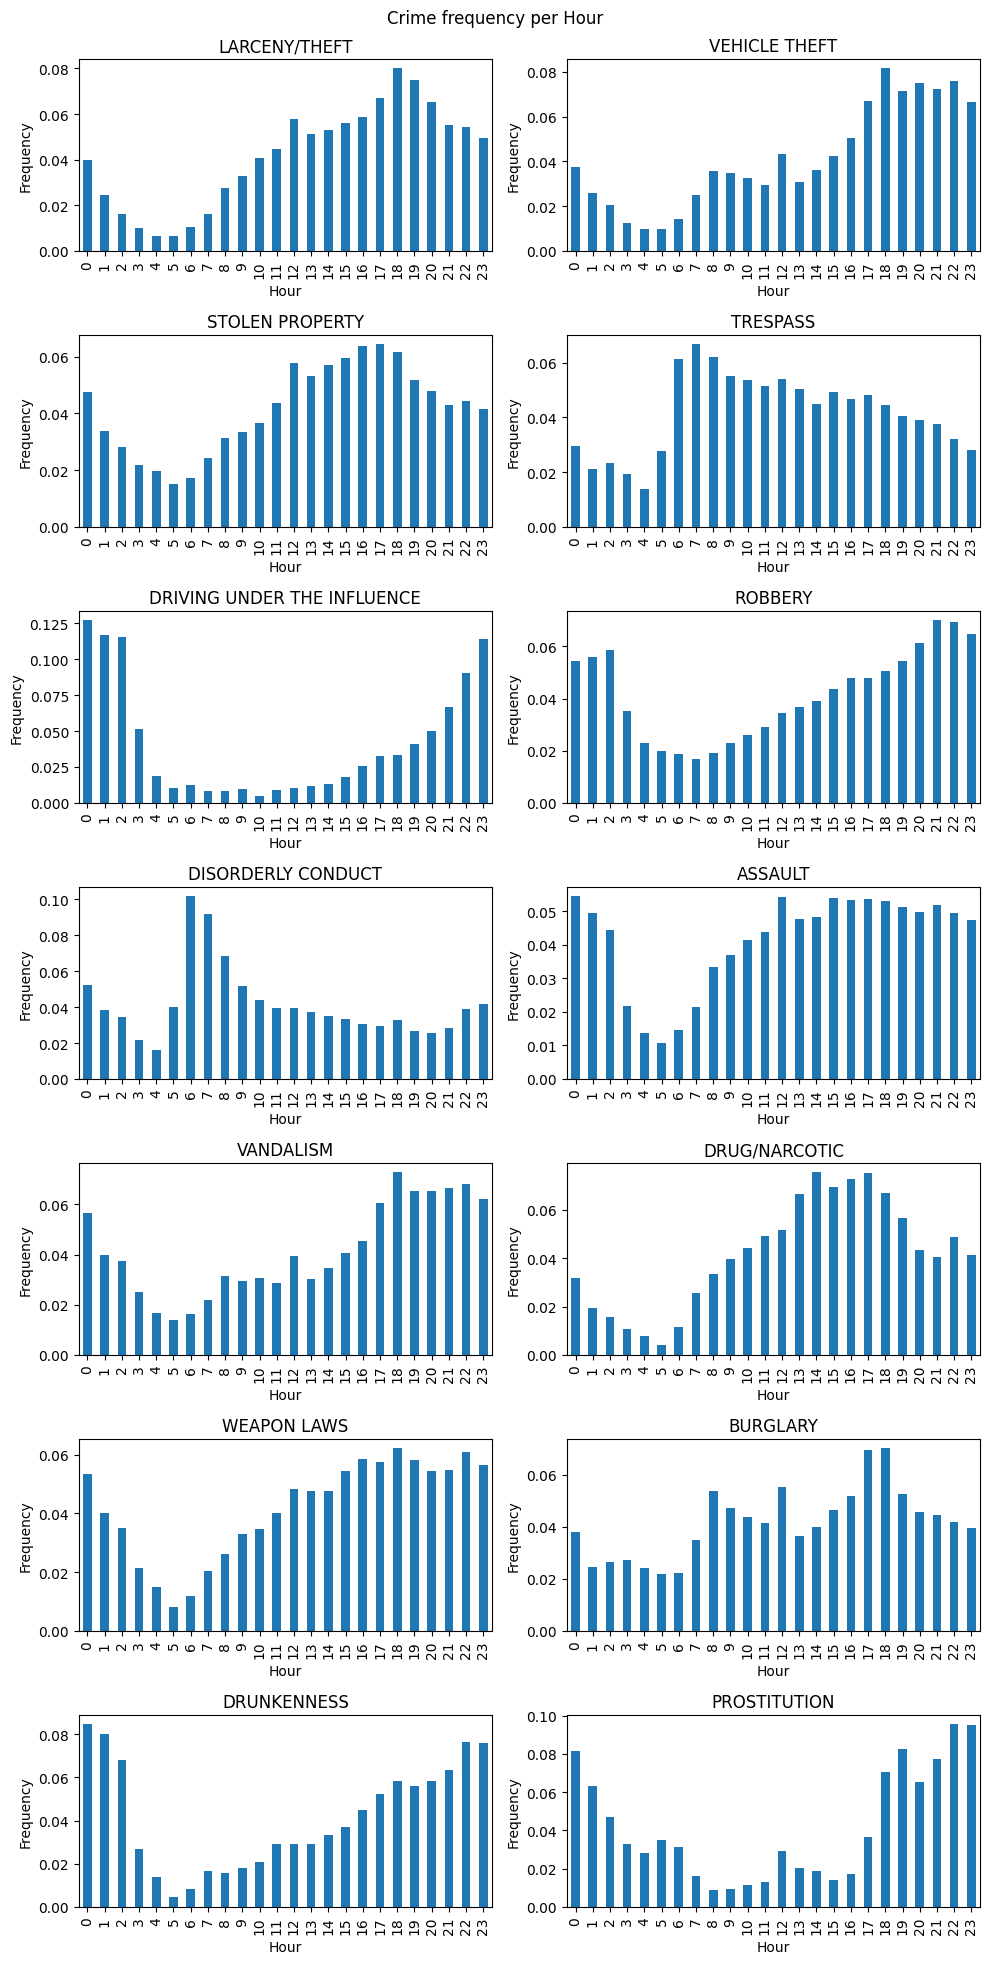

In [7]:
fig = plt.figure(figsize=(10,20))
for i, crime in enumerate(focuscrimes):
    df_i = df_focus.loc[df_focus.Category == crime]
    crimes_per_Hour = df_i['Timestamp'].dt.hour.value_counts().sort_index()
    norm_crimes_per_Hour = crimes_per_Hour/num_crimes_in_category[crime]
    df_crimes_per_hour[crime]=norm_crimes_per_Hour
    ax = fig.add_subplot(7, 2, i + 1)
    norm_crimes_per_Hour.plot(ax=ax, kind='bar', title=crime, xlabel="Hour", ylabel="Frequency")
fig.suptitle('Crime frequency per Hour')
fig.tight_layout(rect=[0, 0, 1, 0.99])
print(df_crimes_per_hour)


If you've followed these steps, your data should be ready! Take a moment to celebrate. We now follow the [Bokeh guide for categorical data](https://docs.bokeh.org/en/latest/docs/user_guide/basic/bars.html):



1. First, let's convert our **Pandas Dataframe** to **Bokeh ColumnDataSource**: 
  > ```python
  > source = ColumnDataSource(your_processed_dataframe)
  > ## it is a standard way to convert your df to bokeh
  > ```

In [8]:
source = ColumnDataSource(df_crimes_per_hour)


2. We also need to create an empty figure (we will add our stuff here later on). Mini sub-exercise: Find the a guide how to define a figure in Bokeh online. Here is a little help:
  > ```python
  > p = figure(...., x_range = FactorRange(factors=hours), ...) 
  > #p is a standard way to call figures in Bokeh
  > #make sure to add x_range. In my case hours is a list on the form ['1', '2', '3' ... , '24']
  > #read up on the FactorRange in the guide
  > #do not forget to add other attributes to the figure, e.g. title, axis names and so on
  > ```

In [9]:
from bokeh.models.ranges import FactorRange
p = figure(x_range = FactorRange(factors=list((map(str, hours)))))


3. Now we are going to add the bars. In order to do so, we will use **vbar** (see the guide for help):
  > ```python
  > bar ={} # to store vbars
  > ### here we will do a for loop:
  > for indx,i in enumerate(focuscrimes):
  >     bar[i] = p.vbar(x='name_of_the_column_that_contain_hours',  top=i, source= src, 
  >                     ### we will create a vbar for each focuscrime
  >                     legend_label=i,  muted_alpha=..., muted = ....) 
  > #i stands for a column that we use, top=y; we are specifying that our numbers comes from column i
  > #read up what legend_label, muted and muted_alpha do... you can add more attributes (you HAVE TO)
  > ```

In [10]:
bar ={} # to store vbars
for indx,i in enumerate(focuscrimes):
    bar[i] = p.vbar(x='index',  top=i, source= source, 
                    legend_label=i,  muted_alpha=0.3, muted = True) 


4. The last thing to do is to make your legend interactive and display the figure:
  > ```python
  > p.legend.click_policy="mute" ### assigns the click policy (you can try to use ''hide'
  > show(p) #displays your plot
  > ```

In [11]:
p.legend.click_policy="mute"
show(p)


5. You will notice that the legend appears in the middle of the figure (and it occludes some of the data). In order to fix this look into [this guide](https://stackoverflow.com/questions/26254619/position-of-the-legend-in-a-bokeh-plot) as a start. Below are some code snippets that you can use to deal with this problem (but read the guide first):
  > ```python
  > items = [] ### for the custom legend // you need to figure out where to add it
  > items.append((i, [bar[i]])) ### figure where to add it
  > legend = Legend(items=..., location=.....) ## figure where to add it
  > p.add_layout(...., ...) ## figure where to add it
  > ### if you read the guide, it will make sense
  > ```

Now you should be able to recreate this amazing visualisation.


**EXTRA feature**: If you're interested in detailed instructions for more Bokeh visualizations for your final project, you can find more inspiration **[here](https://github.com/suneman/socialdata2021/blob/main/lectures/Week8_extra_bokeh.ipynb)**.

In [47]:
from bokeh.palettes import Spectral6
from random import randint
from mycolorpy import colorlist as mcp
source1 = ColumnDataSource(df_crimes_per_hour)
p1 = figure(x_range = FactorRange(factors=list((map(str, hours)))), width=1100)
bar ={} # to store vbars
items = [] 
colors=mcp.gen_color(cmap="jet",n=len(focuscrimes))
for indx,i in enumerate(focuscrimes):
    bar[i] = p1.vbar(x='index',  top=i, source=source,  muted_alpha=0.1, muted = True, color = colors[indx]) 
    items.append((i, [bar[i]]))
legend = Legend(items=items, location=(0, 200))
p1.add_layout(legend, 'right')
p1.legend.click_policy="mute"
show(p1)

## Part 3: Narrative Dataviz

Let's finish up with some reading

*Reading*: [Narrative Visualization: Telling Stories with Data](http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf) by Edward Segel and Jeffrey Heer. We'll read section 1-3 today. (And the rest a bit later).

When you get to section 3 it's fun to open up the examples mentioned by the authors in a browser and explore them as you read the text. 

> *Exercise*: Answer a couple of questions about the paper.
> 
> * What is the *Oxford English Dictionary's* defintion of a narrative?
> * What is your favorite visualization among the examples in section 3? Explain why in a few words.